# Program - Plot cn_map for net SW_down in NE Pacific nudge AM4, MERRA-2, and CERES

**Content**
- Read AM4, MERRA-2, and CERES data, and get variables over a region
- Plot time series using matplotlib

**Reference program:**

**Author:**
Yi-Hsuan chen

**Date:**
October 13, 2023

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
import read_data_mac as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read data functions

### Read CERES data

In [2]:
def read_ceres_var (choice="CERES_July01_30_hourly", varname="swabs_mean"):
    
    da_ceres = read_data.read_ceres_data(choice)
    
    if (varname == "swabs_mean"):
        varname1 = "toa_swabs_1h"
        var_ceres = da_ceres.get(varname1).mean("time")
        
    return var_ceres

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_ceres = read_ceres_var()
    var_ceres
#var_ceres

### Read MERRA-2 data

In [3]:
def read_merra2_var (choice="rad_July01_30_hourly", varname="swabs_mean"):
    da_merra2 = read_data.read_merra2_data(choice)
    da_merra2 = yhc.wrap360(da_merra2)

    if (varname == "swabs_mean"):
        varname1 = "SWTNT"
        var_merra2 = da_merra2.get(varname1).mean("time")
        
    return var_merra2

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_merra2 = read_merra2_var()


### Read nudge AM4 data

In [4]:
def read_am4_var (choice="nudgeAM4_July01_30_hourly", varname="swabs_mean"):
    da_am4 = read_data.read_am4_data(choice)

    if (varname == "swabs_mean"):
        varname1 = "swabs_toa"
        var_am4 = da_am4.get(varname1).mean("time")
        
    return var_am4

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    var_am4 = read_am4_var()
    

### Read ERA5 data

In [5]:
#yhc.lib('xr')

In [6]:
def read_era5_var (choice="era5_2001July_toa_sw", varname="swabs_mean"):
    da_era5 = read_data.read_era5_data(choice)

    if (varname == "swabs_mean"):
        varname1 = "tsr"  # Top net short-wave (solar) radiation
        var_era5 = da_era5.get(varname1).mean("time")
        var_era5 = (var_era5*var_era5.scale_factor + var_era5.add_offset) / 3600.
        var_era5.attrs['units']="W/m2"
    
    #--- rename ERA5 coordinate names
    var_era5 = var_era5.rename({'longitude':'lon', 'latitude':'lat'})
    var_era5 = var_era5.sortby('lat', ascending=True)
        
    return var_era5

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_era5 = read_era5_var()

#var_era5
#var_am4
#var_era5.values[0,0:10]
#var_era5

### Grid interpolation

In [7]:
def interp (var_in, var_target):
    #var_interp = var_in.interp_like(var_target, kwargs={"fill_value": "extrapolate"})
    var_interp = var_in.interp_like(var_target)  # do not extrapolate missing values
    
    return var_interp

#-----------
# do_test
#-----------

do_test=True
#do_test=False
    
if (do_test):
    var_am4 = read_am4_var()
    var_merra2 = read_merra2_var()
    
    var_am4_merra2grid = interp(var_am4, var_merra2)

### Select a region

In [8]:
def select_region(var_in,
                  region="NE_CA",
                 ):
    
    if (region == "NE_CA"):
        lowerlon=235; upperlon=245; lowerlat=28; upperlat=35
    else:
        lowerlon=-1000; upperlon=1000; lowerlat=-1000; upperlat=1000
    
    lon_slice = slice(lowerlon, upperlon)
    lat_slice = slice(lowerlat, upperlat)
        
    var_region = var_in.sel(lat=lat_slice, lon=lon_slice)
    
    return var_region

#-----------
# do_test
#-----------

#do_test=True
do_test=False
    
if (do_test):
    region="ggg"
    var_region = select_region(var_era5) #, region=region)

#var_region
    
#lowerlon=235; upperlon=245; lowerlat=35; upperlat=28
#lon_slice = slice(lowerlon, upperlon)
#lat_slice = slice(lowerlat, upperlat)
        
#var_region = var_era5.sel(lat=lat_slice, lon=lon_slice)
#var_region
#var_era5

### read_data_all - combined all defined functions

In [9]:
def read_data_all():
    
    #--- read CERES, MERRA-2, AM4 data
    var_ceres = read_ceres_var()
    var_merra2 = read_merra2_var()
    var_am4 = read_am4_var()
    
    #--- interpolate into AM4 grids
    var_ceres_am4grid = interp(var_ceres, var_am4)
    var_merra2_am4grid = interp(var_merra2, var_am4)

    #--- select a region
    var_ceres_region = select_region(var_ceres_am4grid)
    var_merra2_region = select_region(var_merra2_am4grid)
    var_am4_region = select_region(var_am4)

    #--- read ERA5 data over the region
    var_era5 = read_era5_var()
    var_era5_am4grid = interp(var_era5, var_am4)
    var_era5_region = select_region(var_era5_am4grid)

    return var_ceres_region, var_merra2_region, var_am4_region, var_era5_region

#-----------
# do_test
#-----------

do_test=True
#do_test=False
    
if (do_test):
    var_ceres_region, var_merra2_region, var_am4_region, var_era5_region = read_data_all()
    
#var_ceres_region
#var_merra2_region
#var_am4_region
#var_era5_region.values

## Plot functions

### ax_def_cn_map

In [10]:
#yhc.lib('fdef')

In [35]:
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

def ax_def_cn_map (ax,
                   map_projection,
                   dict_cn_attrs=None):
    """    
    ----------------------
    Set attributes in cn_map plot using cartopy and matplotlib 

    Input arguments:
        ax: an Axes class variable
        map_projection: ccrs map projection class variable

    Return:
        update ax

    Example:
        map_projection = ccrs.PlateCarree(central_longitude=0)
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_projection})
        ax_def_cn_map(ax, map_projection)
      
    References:
      - Cartopy Tick Labels: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/tick_labels.html

    Date created: 2023-10-15
    ----------------------
    """
    
    #--- add coastline
    ax.add_feature(cfeature.COASTLINE)

    #--- add grid lines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines
    gl.top_labels = False     # turn off labels on the top and right sides
    gl.right_labels = False
    
    #--- draw specific grid lines. I try to find a method to draw every grid line but not all labels. I couldn't find an easy way.
    #                              Perhaps the easiest one is to specify grid lines and let the program to determine the labels.
    lon_grid_lines = [-124, -123, -122, -121, -120, -119, -118, -117, -116]
    gl.xlocator = FixedLocator(lon_grid_lines)
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)

    #--- add title 
    fontsize=12
    ax.set_title(dict_cn_attrs['name'], loc='left', fontsize=fontsize)
    ax.set_title(dict_cn_attrs['units'], loc='right', fontsize=fontsize)
    

In [12]:
#yhc.lib('plt_basic')

### set_dict_cn_attrs

In [13]:
#yhc.lib_func('set_cn_attrs')

In [14]:
from matplotlib.colors import BoundaryNorm

def set_dict_cn_attrs (varname):
    """    
    ----------------------
    Set contour attributes

    Input arguments:
        var: an Xarray.DataArray variable
        varname: variable name

    Return:
        1. return  a dictionary variable, dict_cn_attrs = {'cn_levels','cmap',label,name,units'}
 
 
    Example:
        gg = set_cn_attrs(var_tmp, 'tdt_dyn')
        print(gg['units'])

    References:
        colormaps:  https://matplotlib.org/stable/tutorials/colors/colormaps.html

    Date created: 2023-10-15
    ----------------------
    """
    
    #--- set cn levels
    tdt_dyn_cnlevels = np.arange(-25., 27.5, 2.5)
    qdt_dyn_cnlevels = np.arange(-10., 11, 1.)
    
    #---------------------
    # set cn attributes
    #---------------------
    if (varname == "skdfksjdkf"):
        cn_levels = tdt_dyn_cnlevels
        cmap="c1"
        label = "l1"
        name="n1"
        units="u1"
    
    elif (varname == "tdt_dyn"):
        cn_levels = tdt_dyn_cnlevels
        cmap="coolwarm"
        label = "3D dynamical T tendencies (K/day)"
        name="tdt_dyn"
        units="K/day"
        
    elif (varname == "qdt_dyn"):
        cn_levels = qdt_dyn_cnlevels
        cmap="BrBG"
        label = "3D dynamical Q tendencies (g/kg/day)"
        name="qdt_dyn"
        units="g/kg/day"
        
    elif (varname == "omega"):
        cn_levels = np.arange(-120., 130., 10.)
        cmap="PiYG"
        label = "Omega (hPa/day)"
        name="omega"
        units="hPa/day"

    elif (varname == "uv_div"):
        cn_levels = np.arange(-14., 14., 1.)
        cmap="Spectral"
        label=r"Divergence ($10^6 s^{-1}$)"
        name="Divergence"
        units=r"$10^6 s^{-1}$"

    elif (varname == "swabs_toa"):
        cn_levels = 15
        cmap="plasma"
        name = "TOA net downward SW flux"
        units = r"$W m^{-2}$"
        label = name+" ("+units+")"
        
    elif (varname == "swabs_toa_diff"):
        #cn_levels = np.array([-50, -40, -30, -20, -15, -10, -5, 0, 
        #                         5, 10, 15, 20, 30, 40, 50])
        #cn_levels = np.linspace(-10, 30, 41)
        
        cn_levels = np.arange(-120,140,10)
        
        cmap="Spectral_r"
        name = "TOA net downward SW flux diff"
        units = r"$W m^{-2}$"
        label = name+" ("+units+")"
        norm = BoundaryNorm(cn_levels, ncolors=len(cn_levels))

    else:
        cn_levels = np.array([15])
        cmap = "viridis"
        name = "Var"
        units = "units"
        label = name+" ("+units+")"

    #---------------------------------
    # return a dictionary variable
    #---------------------------------

    dict_cn_attrs = {
        'varname':varname,
        'cn_levels':cn_levels,
        'cmap': cmap,
        'label': label,
        'name': name,
        'units': units,
                  }
    
    return dict_cn_attrs

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_tmp = xr.DataArray(1)
    var_tmp.attrs['standard_name']="ggg"
    var_tmp.attrs['units']="KK"

    dict_cn_attrs = set_dict_cn_attrs('swabs_toa_diff')
    print(dict_cn_attrs)
    print(dict_cn_attrs['cmap'])

In [15]:
#yhc.lib('np')

### plot_box

In [16]:
def plot_box(ax, region="DYCOMS"):
    
    if (region == "DYCOMS"): 
        region_name = "DYCOMS (30-32.2N, 120-123.8W)"
        lowerlat =  30.    # 30N
        upperlat =  32.2   # 32.2N
        lowerlon =  236.2  # 123.8W
        upperlon =  240.   # 120W
    
    lon_range = upperlon - lowerlon
    lat_range = upperlat - lowerlat

    rect = mpatches.Rectangle((lowerlon, lowerlat), lon_range, lat_range, facecolor='none', edgecolor='cyan', linewidth=2, transform=map_projection)
    ax.add_patch(rect)
        

### plot_cn_map

NameError: name 'var_era5' is not defined

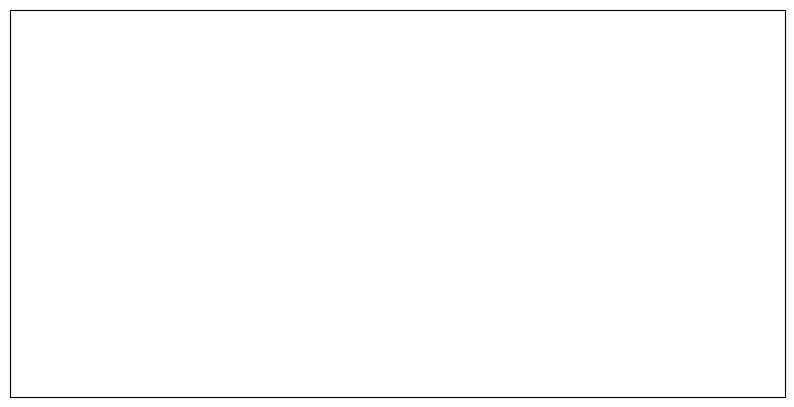

In [17]:
from matplotlib.ticker import FixedLocator

def plot_cn_map(ax, map_projection,
                var, varname,
                do_set_cn_attrs = True, 
                lb_orientation='vertical', lb_shrink=0.45, lb_fontsize=8, 
               ):

    #-------------
    # plot cn_map
    #-------------
    
    if (do_set_cn_attrs):
        
        dict_cn_attrs = set_dict_cn_attrs(varname)  # set contour attributie
        #print(dict_cn_attrs)
        cn_map_region = ax.contourf(var.lon, var.lat, var, extend='both', transform=map_projection, levels=dict_cn_attrs['cn_levels'], cmap=dict_cn_attrs['cmap']) 

    else:
        #--- plot cn_map
        cn_map_region = ax.contourf(var.lon, var.lat, var, transform=map_projection) 

    #--- set cn_map attributes
    ax_def_cn_map(ax, map_projection, dict_cn_attrs=dict_cn_attrs)
    
    #--- plot the colorbar
    cbar = plt.colorbar(cn_map_region, ax=ax, orientation=lb_orientation, shrink=lb_shrink) #, label=dict_cn_attrs['label'])
    #cbar.ax.tick_params(axis='both', which='major', labelsize=5)
    cbar.set_label(label=dict_cn_attrs['label'], fontsize=lb_fontsize)
    
    #-------------
    # plot DYCOMS region
    #-------------    
    plot_box(ax)
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False
    
if (do_test):
    map_projection = ccrs.PlateCarree(central_longitude=0)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_projection})
    var_ceres_region, var_merra2_region, var_am4_region, var_era5_region = read_data_all()

    var_am4Mceres_region = var_am4_region - var_ceres_region
    var_era5Mceres_region = var_era5_region - var_ceres_region

    varname = 'swabs_toa_diff'
    do_set_cn_attrs=True
    #do_set_cn_attrs=False
    #plot_cn_map(ax, map_projection, var_era5Mceres_region, varname, do_set_cn_attrs=do_set_cn_attrs)

    varname = 'swabs_toa'
    plot_cn_map(ax, map_projection, var_era5, varname, do_set_cn_attrs=do_set_cn_attrs)


## Make figures

### read data

In [19]:
#--- read data
var_ceres_region, var_merra2_region, var_am4_region, var_era5_region = read_data_all()

#--- take differences
var_am4Mceres_region = var_am4_region - var_ceres_region
var_merra2Mceres_region = var_merra2_region - var_ceres_region
var_era5Mceres_region = var_era5_region - var_ceres_region


### plot: CERES, AM4-CERES, MERRA2-CERES

In [20]:
#yhc.lib('plt')

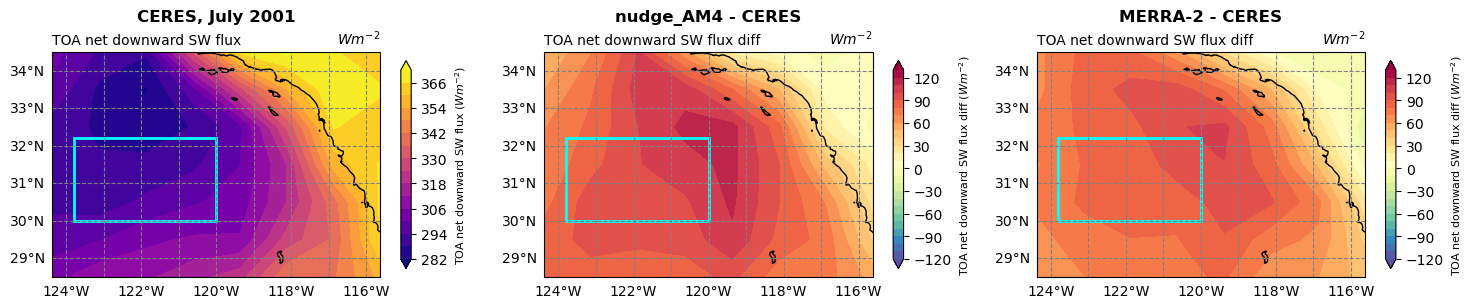

In [21]:
def set_main_title(ax, title, fontsize=12, y=1.1):
    ax.set_title(title, fontsize=fontsize, y=y, fontweight='bold')


map_projection = ccrs.PlateCarree(central_longitude=0)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6), subplot_kw={'projection': map_projection})

plot_cn_map(ax1, map_projection, var_ceres_region, varname="swabs_toa")
set_main_title(ax1, "CERES, July 2001")

plot_cn_map(ax2, map_projection, var_am4Mceres_region, varname="swabs_toa_diff")
set_main_title(ax2, "nudge_AM4 - CERES")

plot_cn_map(ax3, map_projection, var_merra2Mceres_region, varname="swabs_toa_diff")
set_main_title(ax3, "MERRA-2 - CERES")


In [22]:
#yhc.lib('plt_basic')

### plot: CERES, AM4-CERES, ERA5-CERES, MERRA2-CERES

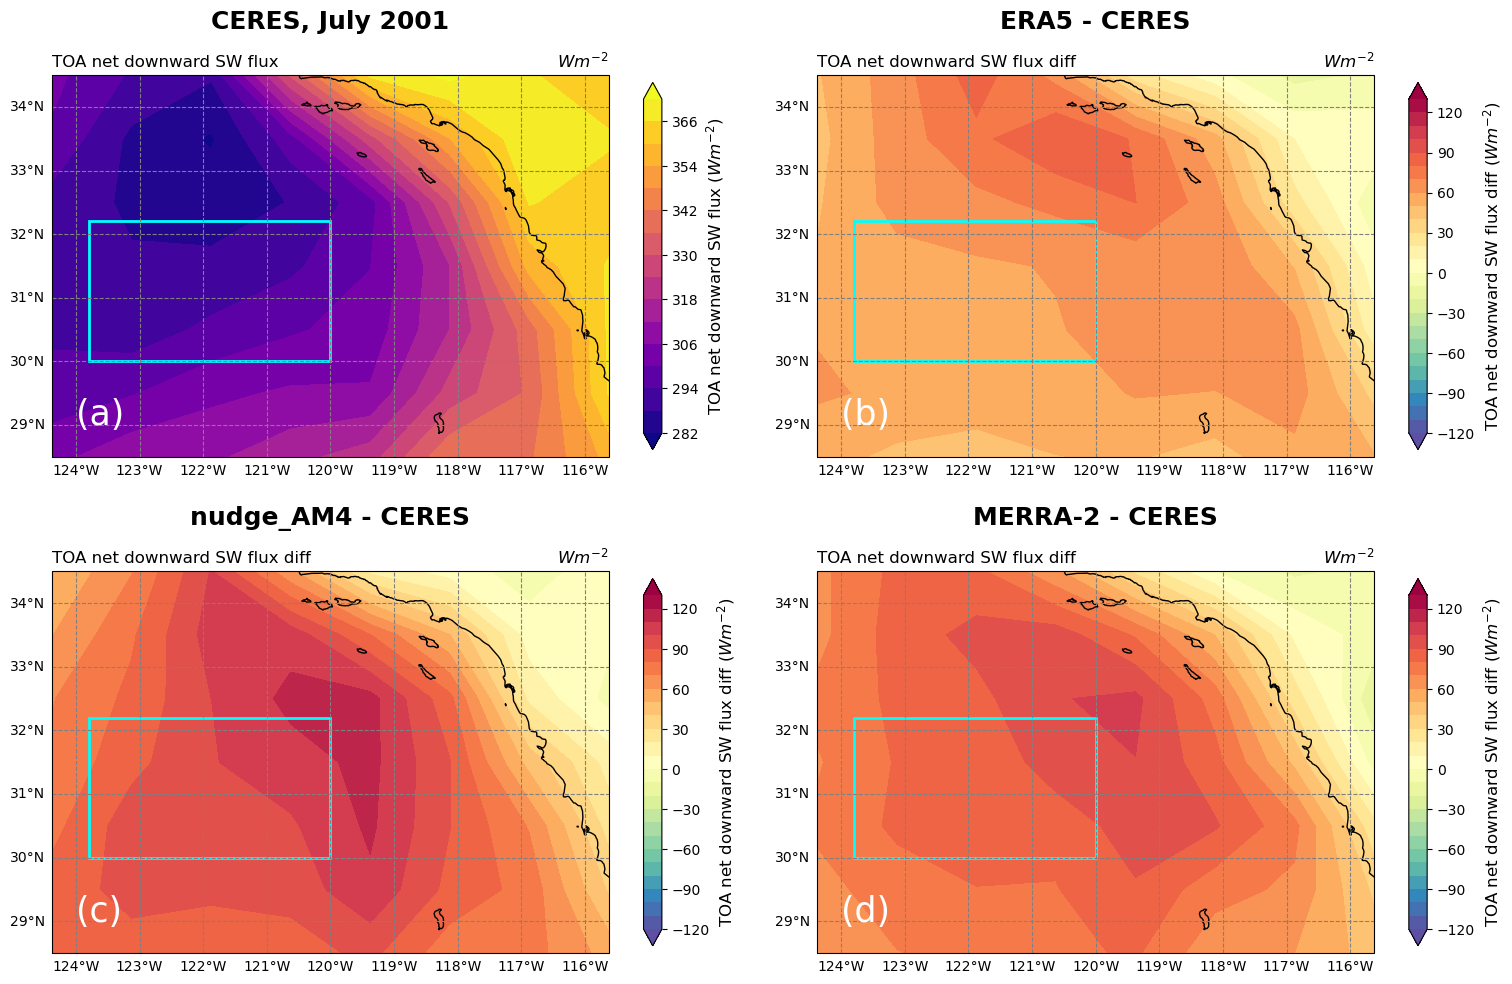

In [36]:
def set_main_title(ax, title, fontsize=18, y=1.1):
    ax.set_title(title, fontsize=fontsize, y=y, fontweight='bold')

def panel_string(ax, text, xx=-124, yy=29, color='w', fontsize=25):
    ax.text(xx, yy, text, color=color, fontsize=fontsize)

    
map_projection = ccrs.PlateCarree(central_longitude=0)
fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2,2,figsize=(16,12), subplot_kw={'projection': map_projection})
fig.tight_layout(pad=5)

lb_orientation='vertical'; lb_shrink=0.65; lb_fontsize=12

plot_cn_map(ax1, map_projection, var_ceres_region, varname="swabs_toa", lb_orientation=lb_orientation, lb_shrink=lb_shrink, lb_fontsize=lb_fontsize)
set_main_title(ax1, "CERES, July 2001")

plot_cn_map(ax3, map_projection, var_am4Mceres_region, varname="swabs_toa_diff", lb_orientation=lb_orientation, lb_shrink=lb_shrink, lb_fontsize=lb_fontsize)
set_main_title(ax3, "nudge_AM4 - CERES")

plot_cn_map(ax2, map_projection, var_era5Mceres_region, varname="swabs_toa_diff", lb_orientation=lb_orientation, lb_shrink=lb_shrink, lb_fontsize=lb_fontsize)
set_main_title(ax2, "ERA5 - CERES")

plot_cn_map(ax4, map_projection, var_merra2Mceres_region, varname="swabs_toa_diff", lb_orientation=lb_orientation, lb_shrink=lb_shrink, lb_fontsize=lb_fontsize)
set_main_title(ax4, "MERRA-2 - CERES")

panel_string(ax1, "(a)")
panel_string(ax2, "(b)")
panel_string(ax3, "(c)")
panel_string(ax4, "(d)")

In [26]:
yhc.lib('plt_basic')


    #-------------
    #
    # matplotlib.pyplot general
    #
    #-------------      

    #-------------------------- 
    #  open fig and ax
    #-------------------------- 

    #      matplotlib.pyplot.subplot, https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html  
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))   # 1 row, 3 columns
    fig, ((ax_1, ax_2, ax_3), (ax_4, ax_5, ax_6)) = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # 2 rows, 3 columns
    fig.suptitle("title", fontsize = 20, y=0.95)   # add title

    #--- set spacing betweeon subplots
    #      https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/ 
    fig.tight_layout()
    #fig.tight_layout(pad=5.0)   # larger pad, larger space betweeon plots

    #-------------
    #
    # Set title and labels
    #
    #-------------  

    #--- main titles  
    fig.suptitle("DYCOMS SCM initial profiles", fontsize=20, y=95)
    
    ax.set_title("

In [ ]:
yhc.lib_func('dd')